In [31]:
import timeit
import time
from pathlib import Path
import random
import sys
import re
sys.path.append(str(Path.cwd().parent / "classes"))
sys.path.append(str(Path.cwd().parent))



import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sim_config import SimConfiguration
from simulation import Simulation


numbers = re.compile(r"\d+\.\d+")


TREES_PATH = Path.cwd() / "chiroptera_data"

In [32]:
def refresh_sim(tree_file):
    seed = time.time_ns()%1000000
    random.seed(seed)
    tree_path = Path(tree_file)

    fasta_path = (tree_path.parent / (tree_path.stem + ".fasta")).resolve()
    fasta_text = fasta_path.read_text().replace("-","")
    fasta_seqs = fasta_text.split(">")[1:]
    sequences_length = [len(seq.replace("\n","")) for seq in fasta_seqs]

    min_seq_len = int(min(sequences_length) *0.8)
    max_seq_len = int(max(sequences_length) *1.1)

    ROOT_SEQUENCE_LENGTH = random.randint(min_seq_len, max_seq_len)

    indel_rate = random.uniform(0.0001, 0.05)
    length_param_alpha = random.uniform(1.01, 2.0)
    print("seed=", seed, "indel_rate=",indel_rate, "Root length=", ROOT_SEQUENCE_LENGTH)

    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=length_param_alpha,
                                indel_truncated_length=50,
                                rate_ins=indel_rate, rate_del=indel_rate,
                                deletion_extra_edge_length=50,
                                switch_factor=200,
                                seed=seed)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)
    return sim

In [33]:
time_log = {"blocklist": [],
            "naive": [],
            "dataset": [],
            "total_branches": [],
            "average_root": []
            }

for tree in TREES_PATH.iterdir():
    if tree.suffix == ".fasta":
        continue
    print(tree.stem)
    times_of_list, times_of_naive = [], []
    root_lengths = []
    for _ in range(5):
        current_sim = refresh_sim(str(tree))
        root_lengths.append(current_sim.sim_nodes[1].length_of_sequence_before)

        blocklist_time = timeit.timeit(current_sim.msa_from_blocklist, number=1)
        times_of_list.append(blocklist_time)
        print("Blocklist time","is", blocklist_time, "sec")
        
        naive_time = timeit.timeit(current_sim.msa_from_naive, number=1)
        print("Naive_time","is", naive_time, "sec")
        times_of_naive.append(naive_time)
    time_log["blocklist"].append(np.mean(times_of_list))
    time_log["naive"].append(np.mean(times_of_naive))
    time_log["dataset"].append(tree.stem)

    tree_text = tree.read_text()
    sum_of_branches = sum(map(float, numbers.findall(tree_text)))
    time_log["total_branches"].append(sum_of_branches)
    time_log["average_root"].append(np.mean(root_lengths))


7288_NT_AL_AA
seed= 933449 indel_rate= 0.03309139305236619 Root length= 354
Blocklist time is 0.004457134999029222 sec
Naive_time is 0.01055836600062321 sec
seed= 783474 indel_rate= 0.04467094232494068 Root length= 462
Blocklist time is 0.006076822999602882 sec
Naive_time is 0.015310495999074192 sec
seed= 959927 indel_rate= 0.029432968614828553 Root length= 474
Blocklist time is 0.006289983999522519 sec
Naive_time is 0.014348767999763368 sec
seed= 391183 indel_rate= 0.010541915819744164 Root length= 541
Blocklist time is 0.006306380000751233 sec
Naive_time is 0.017227689999344875 sec
seed= 414642 indel_rate= 0.0027969672889001118 Root length= 504
Blocklist time is 0.00573505900138116 sec
Naive_time is 0.01473458999862487 sec
199720_NT_AL_AA
seed= 374364 indel_rate= 0.007701667961048195 Root length= 436
Blocklist time is 0.004959558000336983 sec
Naive_time is 0.01110168299965153 sec
seed= 642831 indel_rate= 0.026301740490548352 Root length= 733
Blocklist time is 0.00865077399976144 sec


In [34]:
time_log_df = pd.DataFrame(time_log)

In [35]:
time_log_df["time_ratio"] = (time_log_df["naive"]/ time_log_df["blocklist"] )

In [36]:
time_log_df.to_csv("approximate_bats_runtime.csv", index=False)

<Axes: xlabel='average_root', ylabel='time_ratio'>

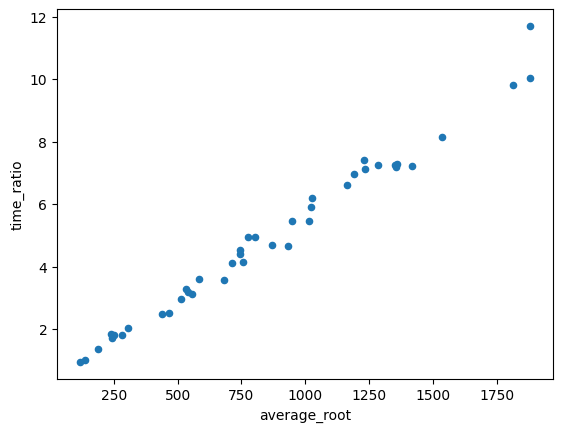

In [37]:
time_log_df.plot(x="average_root", y="time_ratio", kind="scatter")


In [38]:
time_log_df.describe()

,blocklist,naive,total_branches,average_root,time_ratio
count,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.010532,0.067140,1.214909,856.253659,4.892654
std,0.006141,0.066997,0.492098,486.882349,2.623368
min,0.001283,0.001217,0.216151,116.200000,0.948579
25%,0.006260,0.018485,0.927165,513.400000,2.952575
50%,0.009731,0.048023,1.173972,774.200000,4.655280
75%,0.015403,0.111181,1.538575,1231.200000,7.114719
max,0.024714,0.289131,2.340973,1881.600000,11.699270


In [39]:
sorted_time_log_df = time_log_df.sort_values(by="dataset")

In [40]:
simulation_times_df = pd.read_csv("empirical_times_bats.csv")

In [41]:
simulation_times_df = simulation_times_df.sort_values(by="File_Name")

In [42]:
#Real compute time with blocklist method
simulation_times_df["Duration_Hours"].sum()

np.float64(12.190000000000003)

In [43]:
#Inferred compute time with naive method
(simulation_times_df["Duration_Hours"]*sorted_time_log_df["time_ratio"]).sum()

np.float64(59.27089773204057)